<a href="https://colab.research.google.com/github/Sriva29/fuel-consumption-ml/blob/main/Fuel_Consumption_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import kagglehub
import os

Loading Dataset

In [ ]:
# Downloading dataset from Kaggle
path = kagglehub.dataset_download("ahmettyilmazz/fuel-consumption")

print("Path to dataset files:", path)
print("Files in the dataset folder:", os.listdir(path))

csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

if not csv_files:
    raise FileNotFoundError("No CSV file found in the dataset folder.")

file_path = os.path.join(path, csv_files[0])

df = pd.read_csv(file_path)

df.head()

Path to dataset files: /root/.cache/kagglehub/datasets/ahmettyilmazz/fuel-consumption/versions/1
Files in the dataset folder: ['Fuel_Consumption_2000-2022.csv']


,YEAR,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198


In [ ]:
df.describe()

,YEAR,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
count,22556.000000,22556.000000,22556.000000,22556.000000,22556.000000,22556.000000,22556.000000,22556.000000
mean,2011.554442,3.356646,5.854141,12.763513,8.919126,11.034341,27.374534,250.068452
std,6.298269,1.335425,1.819597,3.500999,2.274764,2.910920,7.376982,59.355276
min,2000.000000,0.800000,2.000000,3.500000,3.200000,3.600000,11.000000,83.000000
25%,2006.000000,2.300000,4.000000,10.400000,7.300000,9.100000,22.000000,209.000000
50%,2012.000000,3.000000,6.000000,12.300000,8.400000,10.600000,27.000000,243.000000
75%,2017.000000,4.200000,8.000000,14.725000,10.200000,12.700000,31.000000,288.000000
max,2022.000000,8.400000,16.000000,30.600000,20.900000,26.100000,78.000000,608.000000


In [ ]:
print(df.isnull().sum())

YEAR                0
MAKE                0
MODEL               0
VEHICLE CLASS       0
ENGINE SIZE         0
CYLINDERS           0
TRANSMISSION        0
FUEL                0
FUEL CONSUMPTION    0
HWY (L/100 km)      0
COMB (L/100 km)     0
COMB (mpg)          0
EMISSIONS           0
dtype: int64


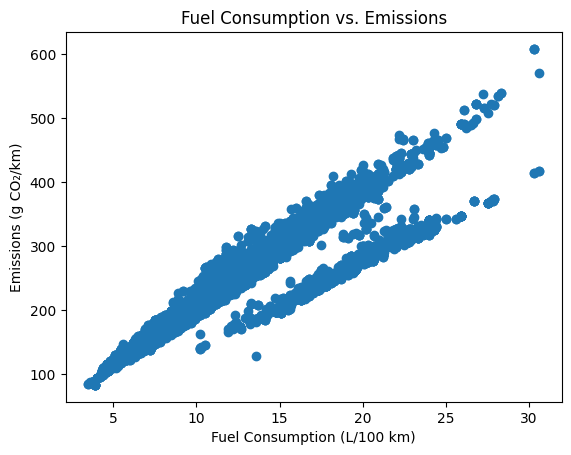

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(df['FUEL CONSUMPTION'], df['EMISSIONS'])
plt.xlabel("Fuel Consumption (L/100 km)")
plt.ylabel("Emissions (g CO₂/km)")
plt.title("Fuel Consumption vs. Emissions")
plt.show()

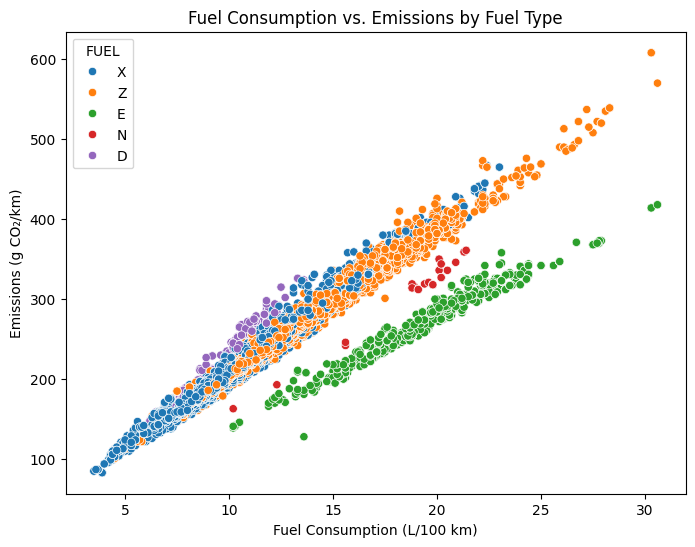

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=df['FUEL CONSUMPTION'], y=df['EMISSIONS'], hue=df['FUEL'])
plt.xlabel("Fuel Consumption (L/100 km)")
plt.ylabel("Emissions (g CO₂/km)")
plt.title("Fuel Consumption vs. Emissions by Fuel Type")
plt.show()


1. Dropping emissions as fuel consumption affects emission
2. Also dropping Make and Model as it doesn't contribute to fuel consumption
3. Dropping COMB (mpg) as it is just a converted column of COMB (L/100)

In [ ]:
print(df.columns)
df.drop(columns=['EMISSIONS', 'MAKE', 'MODEL', 'COMB (mpg)'], inplace=True)
print("Dataset columns:", df.columns)


Index(['YEAR', 'MAKE', 'MODEL', 'VEHICLE CLASS', 'ENGINE SIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUEL', 'FUEL CONSUMPTION', 'HWY (L/100 km)',
       'COMB (L/100 km)', 'COMB (mpg)', 'EMISSIONS'],
      dtype='object')
Dataset columns: Index(['YEAR', 'VEHICLE CLASS', 'ENGINE SIZE', 'CYLINDERS', 'TRANSMISSION',
       'FUEL', 'FUEL CONSUMPTION', 'HWY (L/100 km)', 'COMB (L/100 km)'],
      dtype='object')


In [ ]:
print("Dataset columns:", df.columns)


Dataset columns: Index(['YEAR', 'VEHICLE CLASS', 'ENGINE SIZE', 'CYLINDERS', 'TRANSMISSION',
       'FUEL', 'FUEL CONSUMPTION', 'HWY (L/100 km)', 'COMB (L/100 km)'],
      dtype='object')


###Fuel consumption vs HWY vs COMB

Upon discussion, it made sense to use Combined fuel efficiency as the target -  given that this reflects real world conditions over individual highway vs city fuel consumption values.

In [ ]:
df.drop(columns=['HWY (L/100 km)', 'FUEL CONSUMPTION'], inplace=True)
df.rename(columns={'COMB (L/100 km)': 'fuel_consumption'}, inplace=True)  # Keep it as target label


In [ ]:
df.head()

,YEAR,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,fuel_consumption
0,2000,COMPACT,1.6,4,A4,X,8.1
1,2000,COMPACT,1.6,4,M5,X,7.6
2,2000,MID-SIZE,3.2,6,AS5,Z,10.0
3,2000,MID-SIZE,3.5,6,A4,Z,11.5
4,2000,SUBCOMPACT,1.8,4,A4,X,8.6


In [ ]:
df.duplicated().sum()


4755

In [ ]:
df.drop_duplicates(inplace=True)


In [ ]:
df.duplicated().sum()

0

Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# One-hot encode FUEL type & TRANSMISSION
df = pd.get_dummies(df, columns=['FUEL', 'TRANSMISSION'], drop_first=True)

# Label encode VEHICLE CLASS
label_encoder = LabelEncoder()
df['VEHICLE CLASS'] = label_encoder.fit_transform(df['VEHICLE CLASS'])


In [ ]:
df.head(20)

,YEAR,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,fuel_consumption,FUEL_E,FUEL_N,FUEL_X,FUEL_Z,TRANSMISSION_A3,...,TRANSMISSION_AV,TRANSMISSION_AV1,TRANSMISSION_AV10,TRANSMISSION_AV6,TRANSMISSION_AV7,TRANSMISSION_AV8,TRANSMISSION_M4,TRANSMISSION_M5,TRANSMISSION_M6,TRANSMISSION_M7
0,2000,0,1.6,4,8.1,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2000,0,1.6,4,7.6,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2,2000,4,3.2,6,10.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,2000,4,3.5,6,11.5,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,2000,17,1.8,4,8.6,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
5,2000,17,1.8,4,8.2,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
6,2000,17,1.8,4,8.3,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
7,2000,17,3.0,6,11.6,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
8,2000,17,3.2,6,11.7,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
9,2000,0,1.8,4,9.5,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


###Too many columns - Time to reduce
The encoding steps created too many columns. Time to find out if they are all important

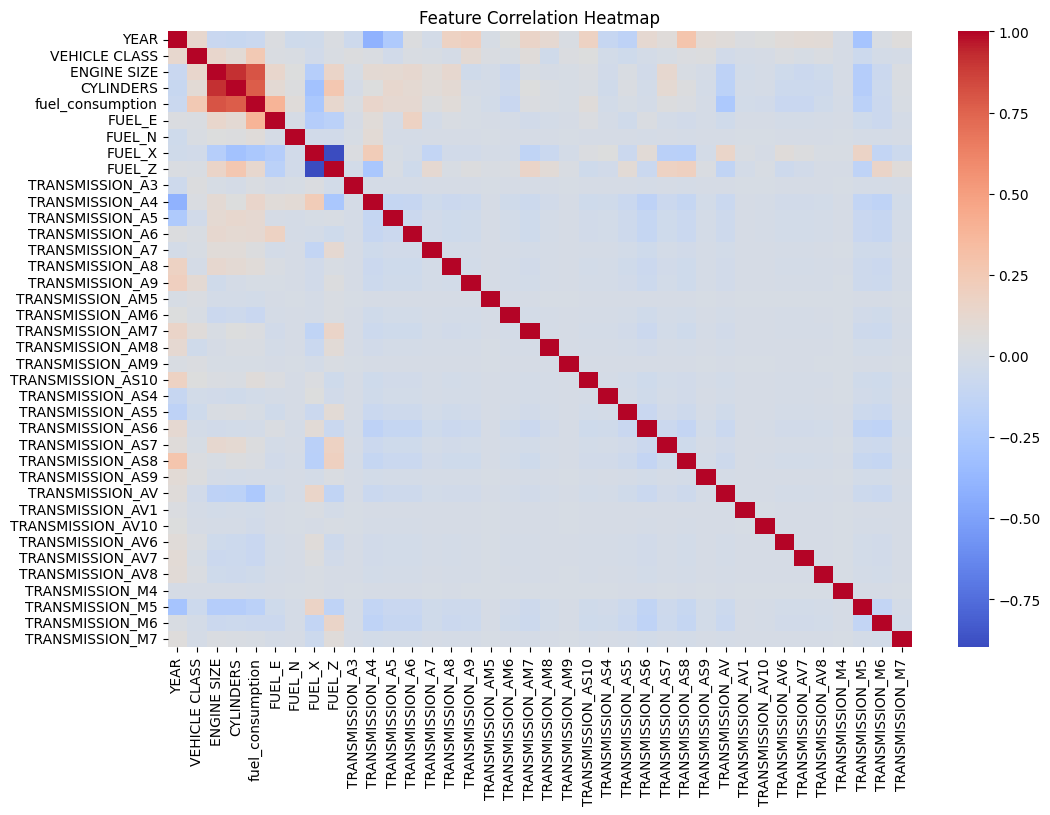

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


###Insights
1. Cylinders and Engine Size highly correlated - Dropping cylinders
2. Grouping transmission into fewer categories - instead of so many transmission types, we will stick to Manual vs Automatic vs CVT and other for other types

In [ ]:
# Drop CYLINDERS since ENGINE SIZE is sufficient
df.drop(columns=['CYLINDERS'], inplace=True)

# Create new transmission categories
df['Automatic'] = df.filter(like='TRANSMISSION_A').sum(axis=1)
df['Manual'] = df.filter(like='TRANSMISSION_M').sum(axis=1)
df['CVT'] = df.filter(like='TRANSMISSION_AV').sum(axis=1)

# Convert to binary (1 if any type exists, else 0)
df['Automatic'] = (df['Automatic'] > 0).astype(int)
df['Manual'] = (df['Manual'] > 0).astype(int)
df['CVT'] = (df['CVT'] > 0).astype(int)

# Drop the original one-hot encoded transmission columns
df.drop(columns=[col for col in df.columns if 'TRANSMISSION' in col], inplace=True)



In [ ]:
# Print final column names and check if everything is correctly formatted
print(df.info())

df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 17801 entries, 0 to 22554
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              17801 non-null  int64  
 1   VEHICLE CLASS     17801 non-null  int64  
 2   ENGINE SIZE       17801 non-null  float64
 3   fuel_consumption  17801 non-null  float64
 4   FUEL_E            17801 non-null  bool   
 5   FUEL_N            17801 non-null  bool   
 6   FUEL_X            17801 non-null  bool   
 7   FUEL_Z            17801 non-null  bool   
 8   Automatic         17801 non-null  int64  
 9   Manual            17801 non-null  int64  
 10  CVT               17801 non-null  int64  
dtypes: bool(4), float64(2), int64(5)
memory usage: 1.2 MB
None


,YEAR,VEHICLE CLASS,ENGINE SIZE,fuel_consumption,FUEL_E,FUEL_N,FUEL_X,FUEL_Z,Automatic,Manual,CVT
0,2000,0,1.6,8.1,False,False,True,False,1,0,0
1,2000,0,1.6,7.6,False,False,True,False,0,1,0
2,2000,4,3.2,10.0,False,False,False,True,1,0,0
3,2000,4,3.5,11.5,False,False,False,True,1,0,0
4,2000,17,1.8,8.6,False,False,True,False,1,0,0


In [ ]:
df[['FUEL_E', 'FUEL_N', 'FUEL_X', 'FUEL_Z']] = df[['FUEL_E', 'FUEL_N', 'FUEL_X', 'FUEL_Z']].astype(int)


In [ ]:
df.head()

,YEAR,VEHICLE CLASS,ENGINE SIZE,fuel_consumption,FUEL_E,FUEL_N,FUEL_X,FUEL_Z,Automatic,Manual,CVT
0,2000,0,1.6,8.1,0,0,1,0,1,0,0
1,2000,0,1.6,7.6,0,0,1,0,0,1,0
2,2000,4,3.2,10.0,0,0,0,1,1,0,0
3,2000,4,3.5,11.5,0,0,0,1,1,0,0
4,2000,17,1.8,8.6,0,0,1,0,1,0,0


In [ ]:
#Dropping year
df.drop(columns=['YEAR'], inplace=True)


In [ ]:
df.head()

,VEHICLE CLASS,ENGINE SIZE,fuel_consumption,FUEL_E,FUEL_N,FUEL_X,FUEL_Z,Automatic,Manual,CVT
0,0,1.6,8.1,0,0,1,0,1,0,0
1,0,1.6,7.6,0,0,1,0,0,1,0
2,4,3.2,10.0,0,0,0,1,1,0,0
3,4,3.5,11.5,0,0,0,1,1,0,0
4,17,1.8,8.6,0,0,1,0,1,0,0


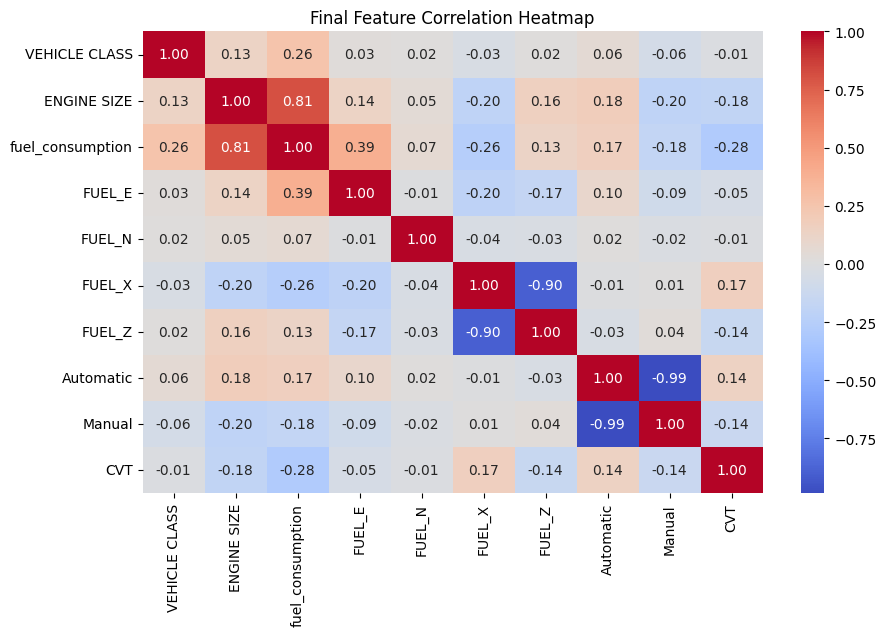

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Final correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Final Feature Correlation Heatmap")
plt.show()


##Model Development

Starting with linear regression

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=['fuel_consumption'])  # Features (without YEAR)
y = df['fuel_consumption']  # Target

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")

Training Set: (14240, 9), Test Set: (3561, 9)


Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate Performance
mae_lr = mean_absolute_error(y_test, y_pred_lr)
# Calculate RMSE without the 'squared' argument and take the square root if needed
mse_lr = mean_squared_error(y_test, y_pred_lr)  # Remove squared=False
rmse_lr = np.sqrt(mse_lr)  # Calculate RMSE manually if needed
r2_lr = r2_score(y_test, y_pred_lr)

print(f"📊 Linear Regression Performance:")
print(f"   MAE: {mae_lr:.3f}")
print(f"   RMSE: {rmse_lr:.3f}")
print(f"   R² Score: {r2_lr:.3f}")

📊 Linear Regression Performance:
   MAE: 1.005
   RMSE: 1.333
   R² Score: 0.773


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate Performance
mae_rf = mean_absolute_error(y_test, y_pred_rf)
# Calculate RMSE by taking the square root of MSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"📊 Random Forest Performance:")
print(f"   MAE: {mae_rf:.3f}")
print(f"   RMSE: {rmse_rf:.3f}")
print(f"   R² Score: {r2_rf:.3f}")

📊 Random Forest Performance:
   MAE: 0.685
   RMSE: 0.951
   R² Score: 0.884


##Random forest wins
Moving on to hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Grid Search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and performance
print(f"Best Parameters: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate performance (without squared=False)
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)  # This is MSE
rmse_best_rf = mse_best_rf ** 0.5  # Manually calculate RMSE
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"📊 Tuned Random Forest Performance:")
print(f"   MAE: {mae_best_rf:.3f}")
print(f"   RMSE: {rmse_best_rf:.3f}")
print(f"   R² Score: {r2_best_rf:.3f}")


Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
📊 Tuned Random Forest Performance:
   MAE: 0.685
   RMSE: 0.950
   R² Score: 0.885


<ipython-input-134-d4a3db0d680e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


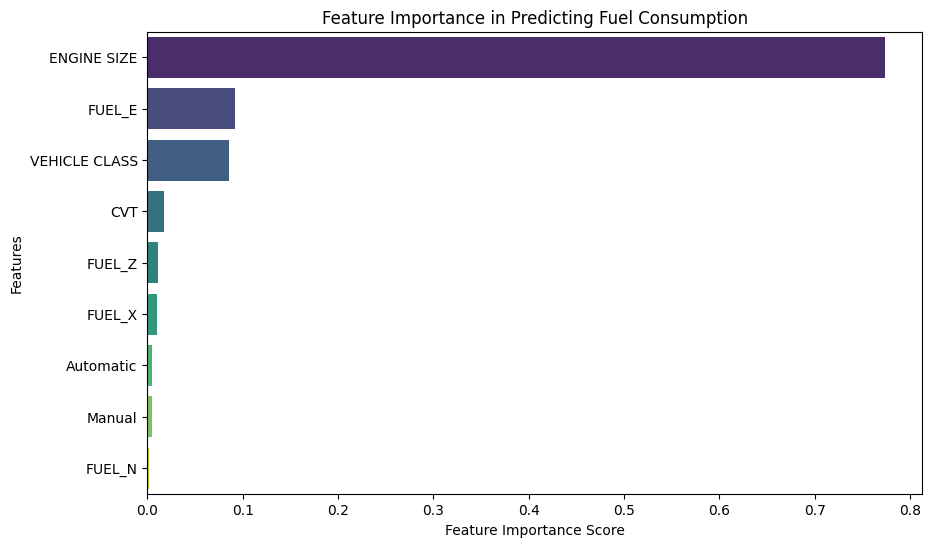

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importance = best_rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting Fuel Consumption")
plt.show()


###Conclusion
Engine size is the biggest predictor in fuel consumption for vehicles.